<a href="https://colab.research.google.com/github/ARBasharat/AudioClassification/blob/master/AudioClassification2D_CVN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contact: abbash@iu.edu <br/>
Audio Spectrogram Classification using Convolutional Variational Network and Random Forest <br/>

# Import Libraries

In [26]:
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Read Data from Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

train = np.load("drive/My Drive/AudioClassification/audio_train.npy").astype('float32')
test = np.load("drive/My Drive/AudioClassification/audio_test.npy").astype('float32')
train_labels_df = pd.read_csv("drive/My Drive/AudioClassification/labels_train.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Process the data

In [4]:
train_labels = train_labels_df.to_numpy()[:,1]
labels_categorical = keras.utils.to_categorical(train_labels)
print("Training Labels:", labels_categorical.shape)

# train and test combined
train_data = np.concatenate((train, test), axis=0)
print("Training Data:", train_data.shape)

Training Labels: (942, 10)
Training Data: (1500, 30000)


In [5]:
## We switch between white and normal noise randomly

def add_white_noise(data, rate = 0.05):
  data_with_white_noise = data + rate * np.random.randn(len(data))
  return data_with_white_noise

'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
def add_normal_distributed_noise(data, rate = 0.09, sr = 30000):
  data_with_noramlized_noise = data + rate * np.random.normal(0, 1, len(data))
  return data_with_noramlized_noise

'''
Time Shifting
Permissible factor values = sr/10
'''
def add_time_shift(data, sr = 30000):
  data_with_time_shift = np.roll(data, int(sr/10))
  return data_with_time_shift

'''
Time Stretching
Permissible factor values = 0 < x < 1.0
'''
def add_time_stretch(data, factor = 0.8):
  data_with_time_strect = librosa.effects.time_stretch(data, factor)
  return data_with_time_strect


'''
Pitch shifting
Permissible factor values = -5 <= x <= 5
'''
def add_pitch_shift(data, sr = 30000, steps = -7):
  data_with_pitch_shift = librosa.effects.pitch_shift(data, sr, n_steps = steps)
  return data_with_pitch_shift

In [6]:
# Get augmented_training data equal to size of real data
def get_augmented_data_two_times(X_train_original, y_train_original):
  new_data = []
  new_labels = []
  for i in range(0, len(X_train_original)):
    data = X_train_original[i]
    label = y_train_original[i]
    choice = random.choice([1, 2, 3, 4, 5]) ## Used for selecting between white noise and normalized noise
    ## get augmented data
    new_data.append(data)
    if choice == 1:
      new_data.append(add_white_noise(data))
    elif choice == 2:
      new_data.append(add_normal_distributed_noise(data))
    elif choice == 3:
      new_data.append(add_time_shift(data))
    elif choice == 4:
      new_data.append(add_time_stretch(data))
    elif choice == 5:
      new_data.append(add_pitch_shift(data))
    ## get labels
    new_labels.append(label)
    new_labels.append(label)

  ## Shuffle data
  compressed = list(zip(new_data, new_labels))
  random.shuffle(compressed)
  new_data, new_labels = zip(*compressed)

  ## Get augmented train data and labels
  train_data = np.array(new_data)
  y_train = np.array(new_labels)
  return train_data, y_train

#train_data, y_train = get_augmented_data_two_times(X_train_original, y_train_original)
#print(train_data.shape, y_train.shape)

In [8]:
def get_spectrogram(in_data):
  spectrogram = []
  for elem in in_data:
    converted = librosa.stft(elem)
    spectrum, _ = librosa.magphase(converted)
    spectrum = np.abs(spectrum).astype(np.float32)
    norm = spectrum.max()
    spectrum /= norm
    result = np.zeros((1028, 76))
    result[:spectrum.shape[0],:spectrum.shape[1]] = spectrum
    result = result.reshape((result.shape[0], result.shape[1], 1))
    spectrogram.append(result)
  spectrogram = np.array(spectrogram)
  return spectrogram

In [18]:
X_train = get_spectrogram(train_data)
X_test = get_spectrogram(test)
X_val = get_spectrogram(train)
print("Train Shapes: ", X_train.shape)
print("Test Shapes: ", X_test.shape)

Train Shapes:  (1500, 1028, 76, 1)
Test Shapes:  (558, 1028, 76, 1)


# **Model Definations**

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 1028 * 76
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Train Models with 2 Latent Dimensions to get an idea of CVN performance

In [14]:
latent_dim = 2
batch_size = 32

In [15]:
encoder_inputs = keras.Input(shape=X_train[0].shape)
x = layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding="same")(encoder_inputs)
x = layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Conv2D(256, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1028, 76, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 1028, 76, 32) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 1028, 76, 32) 4128        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 514, 38, 32)  0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(257 * 19 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((257, 19, 64))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 312512)            937536    
_________________________________________________________________
reshape (Reshape)            (None, 257, 19, 64)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 257, 19, 256)      147712    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 257, 19, 128)      295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 514, 38, 64)       73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 514, 38, 64)       3692

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(X_train, X_train, epochs=100, batch_size=batch_size)

Epoch 1/100
47/47 [==============================] - 23s 483ms/step - loss: 9691.3011 - reconstruction_loss: 7150.7911 - kl_loss: 2540.5100
Epoch 2/100
47/47 [==============================] - 21s 455ms/step - loss: 1017.3155 - reconstruction_loss: 1017.3153 - kl_loss: 1.6871e-04
Epoch 3/100
47/47 [==============================] - 22s 461ms/step - loss: 893.6787 - reconstruction_loss: 893.6785 - kl_loss: 1.9816e-04
Epoch 4/100
47/47 [==============================] - 22s 470ms/step - loss: 863.4549 - reconstruction_loss: 863.1231 - kl_loss: 0.3318
Epoch 5/100
47/47 [==============================] - 23s 479ms/step - loss: 856.4476 - reconstruction_loss: 855.6096 - kl_loss: 0.8381
Epoch 6/100
47/47 [==============================] - 23s 490ms/step - loss: 850.0865 - reconstruction_loss: 849.1678 - kl_loss: 0.9187
Epoch 7/100
47/47 [==============================] - 23s 498ms/step - loss: 847.2684 - reconstruction_loss: 846.3931 - kl_loss: 0.8753
Epoch 8/100
47/47 [=====================

In [19]:
## Get embeded data
a, b, X_val_encoded = encoder.predict(X_val)
print(X_val_encoded.shape)

(942, 2)


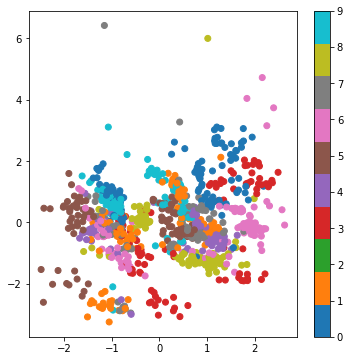

In [20]:
## Generate plot
plt.figure(figsize=(6, 6))
cmap = plt.get_cmap('tab10', 10)
plt.scatter(X_val_encoded[:, 0], X_val_encoded[:, 1], c=train_labels, cmap=cmap)
plt.colorbar()
plt.show()

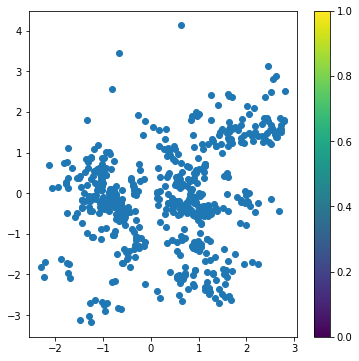

In [21]:
a, b, X_test_encoded = encoder.predict(X_test)
## Generate plot
plt.figure(figsize=(6, 6))
cmap = plt.get_cmap('tab10', 10)
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], cmap=cmap)
plt.colorbar()
plt.show()

# Train the CVN model with 50 Latent Dimensions for training 

In [22]:
latent_dim = 50
batch_size = 32

In [23]:
encoder_inputs = keras.Input(shape=X_train[0].shape)
x = layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding="same")(encoder_inputs)
x = layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Conv2D(256, kernel_size=(2, 2), activation='relu', padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1028, 76, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 1028, 76, 32) 160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 1028, 76, 32) 4128        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 514, 38, 32)  0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [24]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(257 * 19 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((257, 19, 64))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 312512)            15938112  
_________________________________________________________________
reshape_1 (Reshape)          (None, 257, 19, 64)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 257, 19, 256)      147712    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 257, 19, 128)      295040    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 514, 38, 64)       73792     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 514, 38, 64)       3692

In [25]:
vae_2 = VAE(encoder, decoder)
vae_2.compile(optimizer=keras.optimizers.Adam())
history_2 = vae_2.fit(X_train, X_train, epochs=100, batch_size=batch_size)

Epoch 1/100
47/47 [==============================] - 21s 457ms/step - loss: 2076679.5458 - reconstruction_loss: 28129.4606 - kl_loss: 2048550.0266
Epoch 2/100
47/47 [==============================] - 22s 462ms/step - loss: 943.6291 - reconstruction_loss: 940.8402 - kl_loss: 2.7888
Epoch 3/100
47/47 [==============================] - 22s 469ms/step - loss: 850.0538 - reconstruction_loss: 847.7381 - kl_loss: 2.3158
Epoch 4/100
47/47 [==============================] - 22s 476ms/step - loss: 825.3289 - reconstruction_loss: 822.9379 - kl_loss: 2.3910
Epoch 5/100
47/47 [==============================] - 23s 484ms/step - loss: 815.5626 - reconstruction_loss: 812.9671 - kl_loss: 2.5954
Epoch 6/100
47/47 [==============================] - 23s 492ms/step - loss: 801.7752 - reconstruction_loss: 799.2878 - kl_loss: 2.4874
Epoch 7/100
47/47 [==============================] - 23s 495ms/step - loss: 789.7108 - reconstruction_loss: 787.0667 - kl_loss: 2.6441
Epoch 8/100
47/47 [========================

In [27]:
## Get embeded data with 50 latent dimensions
a, b, X_val_encoded = encoder.predict(X_val)
print(X_val.shape, X_val_encoded.shape)

(942, 1028, 76, 1) (942, 50)


In [28]:
## Split data to train and test Random Forest
train_x, test_x, train_y, test_y = train_test_split(X_val_encoded, train_labels, 
                                              test_size=0.15, random_state=42)

In [30]:
clf = RandomForestClassifier(max_depth=30, random_state=0)
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
rfc_predict = clf.predict(test_x)

print("=== Confusion Matrix ===")
print(confusion_matrix(test_y, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_y, rfc_predict))
print('\n')

=== Confusion Matrix ===
[[13  0  0  0  0  0  0  0  0]
 [ 1 15  1  0  0  0  0  0  1]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0]
 [ 0  1  0  0 15  0  0  0  2]
 [ 0  0  1  0  0 17  0  0  0]
 [ 0  0  0  0  0  0 11  0  2]
 [ 0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0 17]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.94      0.83      0.88        18
           3       0.90      1.00      0.95        18
           4       1.00      1.00      1.00        14
           5       1.00      0.83      0.91        18
           6       1.00      0.94      0.97        18
           7       1.00      0.85      0.92        13
           8       1.00      1.00      1.00        13
           9       0.77      1.00      0.87        17

    accuracy                           0.94       142
   macro avg       0.95      0.94      0.94       142
weighted avg       0.9

In [32]:
a, b, x_test_encoded = encoder.predict(X_test)
test_pred = clf.predict(x_test_encoded)
test_pred

array([5, 9, 4, 1, 4, 5, 9, 0, 3, 7, 7, 3, 1, 8, 0, 7, 7, 3, 5, 3, 3, 3,
       9, 3, 3, 5, 7, 7, 0, 4, 4, 1, 3, 1, 6, 3, 1, 3, 9, 9, 0, 1, 5, 9,
       4, 7, 3, 3, 3, 6, 9, 6, 0, 0, 8, 3, 5, 3, 3, 3, 3, 7, 8, 7, 0, 0,
       4, 6, 3, 3, 3, 4, 3, 5, 1, 4, 9, 7, 4, 5, 0, 1, 6, 9, 7, 3, 3, 3,
       1, 6, 0, 8, 0, 8, 7, 7, 3, 3, 3, 3, 6, 3, 7, 3, 7, 3, 3, 4, 1, 3,
       3, 0, 7, 7, 1, 9, 9, 4, 5, 1, 5, 9, 3, 4, 3, 3, 3, 3, 0, 3, 8, 7,
       3, 3, 3, 3, 7, 3, 5, 4, 4, 1, 4, 8, 7, 3, 3, 0, 1, 5, 0, 9, 5, 3,
       3, 9, 3, 9, 4, 0, 3, 3, 3, 3, 3, 7, 7, 3, 5, 0, 4, 0, 8, 8, 6, 3,
       3, 3, 6, 5, 5, 1, 0, 7, 3, 1, 0, 7, 3, 3, 9, 6, 1, 4, 8, 8, 4, 5,
       3, 3, 7, 5, 5, 1, 6, 6, 9, 9, 6, 3, 3, 9, 5, 9, 1, 7, 0, 5, 1, 4,
       9, 3, 3, 3, 6, 4, 8, 5, 8, 5, 7, 0, 3, 7, 5, 8, 6, 8, 3, 3, 6, 9,
       6, 9, 4, 5, 0, 7, 9, 3, 9, 3, 3, 8, 0, 5, 8, 7, 7, 3, 3, 3, 7, 3,
       3, 3, 5, 4, 5, 8, 6, 9, 3, 3, 3, 0, 9, 0, 9, 1, 1, 5, 1, 3, 3, 9,
       3, 8, 7, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8,

In [33]:
pd.DataFrame(test_pred).to_csv("submission_RF.csv")

In [34]:
import collections
counter=collections.Counter(test_pred)
print(counter)

Counter({3: 189, 7: 59, 1: 54, 4: 48, 5: 46, 0: 45, 9: 43, 8: 42, 6: 32})
